In [1]:
import pyspedas
import pytplot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from modules.calparam import *


#swe_vars = pyspedas.wind.swe(trange=['2003-11-20','2003-11-23'],datatype='h1',varnames=['BX','BY','BZ','Proton_Np_moment','Proton_W_moment'],downloadonly=True,time_clip=True)

**Using CDFLIB**

In [2]:
import cdflib
dt = "20-22 Nov 2003"
cdf_file = cdflib.CDF(r'wind_h1s_swe_20100410000119_20100411235822.cdf')

In [3]:
cdf_file.cdf_info()

CDFInfo(CDF=WindowsPath('C:/Users/KEVAL/Desktop/ICME-PRoject/ICME-ML/wind_h1s_swe_20100410000119_20100411235822.cdf'), Version='2.7.2', Encoding=1, Majority='Column_major', rVariables=[], zVariables=['Epoch', 'Proton_VX_moment', 'Proton_VY_moment', 'Proton_VZ_moment', 'Proton_W_moment', 'Proton_Np_moment', 'BX', 'BY', 'BZ', 'Ang_dev'], Attributes=[{'TITLE': 'Global'}, {'Project': 'Global'}, {'Discipline': 'Global'}, {'Source_name': 'Global'}, {'Descriptor': 'Global'}, {'Data_type': 'Global'}, {'File_naming_convention': 'Global'}, {'Data_version': 'Global'}, {'PI_name': 'Global'}, {'PI_affiliation': 'Global'}, {'TEXT': 'Global'}, {'Instrument_type': 'Global'}, {'Mission_group': 'Global'}, {'Logical_source': 'Global'}, {'Logical_file_id': 'Global'}, {'Logical_source_description': 'Global'}, {'Time_resolution': 'Global'}, {'Generated_by': 'Global'}, {'Generation_date': 'Global'}, {'MODS': 'Global'}, {'LINK_TEXT': 'Global'}, {'LINK_TITLE': 'Global'}, {'HTTP_LINK': 'Global'}, {'spase_Datase

In [4]:
time_range= cdflib.cdfepoch.to_datetime(cdf_file.varget('epoch'))
time_range[-1]

numpy.datetime64('2010-04-11T23:58:22.630000')

**MATPLOTLIB**

**Deriving the Parameters**

In [5]:
#plotting variables

from modules.calparam import *


BX,BY,BZ,b_mag = bmagnitude(cdf_file)


p_density = thresold(cdf_file.varget('Proton_Np_moment'),1e4)


vp = Vp_vec(cdf_file)

temp = Temperature(cdf_file)


p_beta = plasma_beta(p_density,b_mag,temp)

tehta_angle,phi_angle = angels(BX,BY,BZ,b_mag)


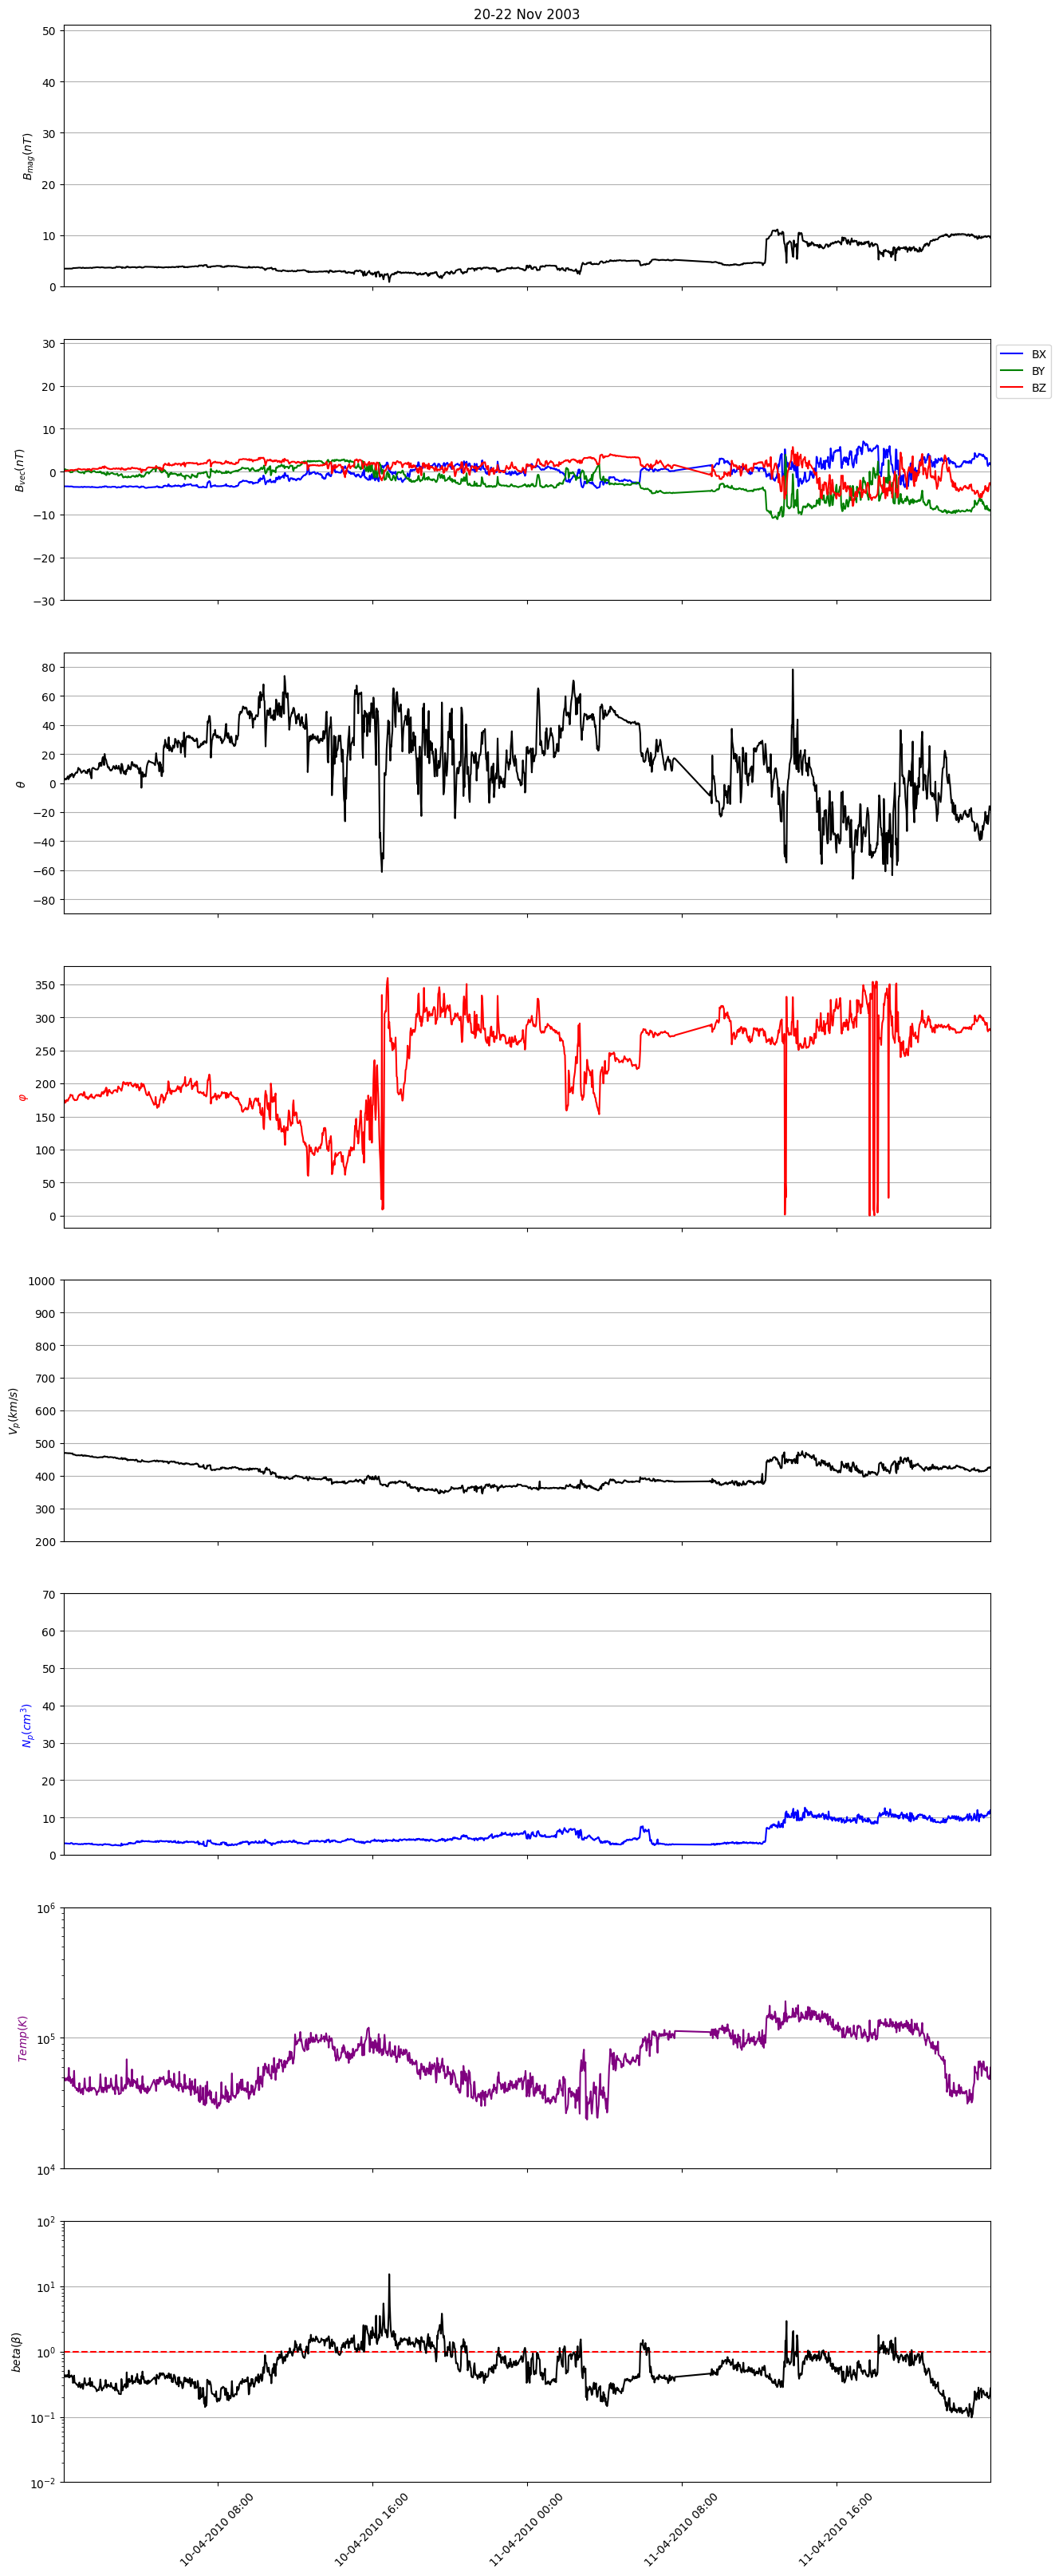

In [6]:
from modules.plotter import Plotting

plot  = Plotting(dt)

plot.ipplot(time_range,b_mag,BX,BY,BZ,tehta_angle,phi_angle,vp,p_density,temp,p_beta)


# 3days-Plotting systen

In [ ]:
from datetime import datetime, timedelta


def read_files_in_date_range(start_date, end_date):
    date_format = "%d-%m-%Y"
    current_date = datetime.strptime(start_date, date_format)
    end_date = datetime.strptime(end_date, date_format)

    flag =False
    
    count =0
    while flag!=True:
        
        print(current_date)
        loop_date = current_date
        dataset = []
        date_log = []
        for day in range(1,4):
            
            dataset.append(f"wi_h1_swe_{loop_date.strftime("%Y%m%d")}_v01.cdf")
            
            #combine -> dataset
            #IP_POLT

            date_log.append(loop_date.strftime("%Y%m%d"))
            
            if end_date.strftime("%Y%m%d") in date_log:
                flag = True
                break

            loop_date += timedelta(days=1)

        print(dataset)
        count+=1

        dataset = []
        date_log =[]
        current_date += timedelta(days=1)

    return count



st  = '01-01-2003'
end = '10-01-2003'




test =  read_files_in_date_range(st, end)


In [ ]:
from modules.combine_cdf import merge_cdf
import cdflib

cd1 = cdflib.CDF(r'wind_data\swe\swe_h1\2003\wi_h1_swe_20030120_v01.cdf')
cd2 = cdflib.CDF(r'wind_data\swe\swe_h1\2003\wi_h1_swe_20030121_v01.cdf')
cd3 = cdflib.CDF(r'wind_data\swe\swe_h1\2003\wi_h1_swe_20030122_v01.cdf')

days_3 = merge_cdf(cd1,cd2,cd3)



**3days calculations**

In [ ]:
days_3.keys()

In [ ]:
#plotting variables

from modules.calparam import *

BX,BY,BZ,b_mag = bmagnitude(days_3)


p_density = days_3['Proton_Np_moment']
if len(p_density[p_density >= 10000]) >= 1:
    p_density[p_density >= 10000] = np.nan
    p_density = pd.Series(p_density).interpolate().values

vp = Vp_vec(days_3)

temp = Temperature(days_3)


p_beta = plasma_beta(p_density,b_mag,temp)

tehta_angle,phi_angle = angels(BX,BY,BZ,b_mag)


In [ ]:
from modules.plotter import Plotting
import matplotlib.pyplot as plt
# plt.ioff()
plot  = Plotting()

t = plot.ipplot(days_3['t_range'],b_mag,BX,BY,BZ,tehta_angle,phi_angle,vp,p_density,temp,p_beta)

t.savefig('myimage2.jpg', format='jpg', dpi=300)